
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [9]:
# # Q: Qfunction/Encoder/Classifier
# def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('qfunction', reuse=reuse):        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=states, units=hidden_size)
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=action_size)        
#         #predictions = tf.nn.softmax(logits)

#         # return actions logits
#         return logits

In [12]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fuse/merge states and actions together
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        #logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)
        
        # Split states and actions together
        next_state_logits, actions_logit = tf.split(axis=1, num_or_size_splits=[state_size, action_size], value=nl2) 
        # states sigmoid/regression/continuous and actions softmax/classification/discrete
        
        # return next_states_logits
        return next_state_logits, actions_logit

In [13]:
# D: Descriminator/Reward function
def discriminator(next_states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=next_states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [10]:
def model_loss(states,  actions, next_states, targetQs, # model input data 
               state_size, action_size, hidden_size): # model init
    # GAN: Generate next states
    next_states_logits, actions_logits = generator(states=states, actions=actions, 
                                   action_size=action_size, state_size=state_size, hidden_size=hidden_size)
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    #actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(indices=actions, depth=action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    g_loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    # GAN: Discriminate between fake and real
    d_logits_fake = discriminator(next_states=next_states_logits, hidden_size=hidden_size, reuse=False)
    d_logits_real = discriminator(next_states=next_states, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - G-learning
    g_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    g_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.zeros_like(d_logits_real)))
    g_loss += g_loss_real + g_loss_fake
    
    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [11]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [12]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [15]:
train_episodes = 250           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                rewards_real_list.append((ep, rewards_real_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            #             # Train the model
            #             feed_dict = {model.states: states, model.next_states: next_states}
            #             next_actions_logits, rewards_fake, rewards_real = sess.run([model.actions_logits, 
            #                                                                         model.rewards_fake, model.rewards_real], 
            #                                                                        feed_dict)
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0) # NOTE: action size

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions,
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 14.0 Average reward fake: 0.5146830081939697 Average reward real: 0.5908793807029724 Training q_loss: 0.3496 Training g_loss: 1.5795 Training d_loss: 1.2742 Explore P: 0.9986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 21.0 Average reward fake: 0.3195183277130127 Average reward real: 0.5851050019264221 Training q_loss: 0.7967 Training g_loss: 2.3430 Training d_loss: 1.0126 Explore P: 0.9965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 23.0 Average reward fake: 0.6939302086830139 Average reward real: 0.6864286065101624 Training q_loss: 4.4988 Training g_loss: 2.4247 Training d_loss: 2.3269 Explore P: 0.9943


-------------------------------------------------------------------------------
Episode: 23 Total reward: 18.0 Average reward fake: 0.4960657060146332 Average reward real: 0.492096871137619 Training q_loss: 19.0413 Training g_loss: 1.3769 Training d_loss: 1.4086 Explore P: 0.9459
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 14.0 Average reward fake: 0.5066484808921814 Average reward real: 0.49603408575057983 Training q_loss: 19.4808 Training g_loss: 1.3667 Training d_loss: 1.4096 Explore P: 0.9446
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 15.0 Average reward fake: 0.5011744499206543 Average reward real: 0.49497756361961365 Training q_loss: 44.8162 Training g_loss: 1.3750 Training d_loss: 1.3996 Explore P: 

-------------------------------------------------------------------------------
Episode: 46 Total reward: 16.0 Average reward fake: 0.35242173075675964 Average reward real: 0.6497968435287476 Training q_loss: 346.5304 Training g_loss: 2.1710 Training d_loss: 0.8098 Explore P: 0.8969
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 23.0 Average reward fake: 0.29096561670303345 Average reward real: 0.638033926486969 Training q_loss: 661.7241 Training g_loss: 2.3400 Training d_loss: 0.7055 Explore P: 0.8948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 46.0 Average reward fake: 0.13827085494995117 Average reward real: 0.8072196245193481 Training q_loss: 704.8333 Training g_loss: 4.4214 Training d_loss: 0.4472 Explore

-------------------------------------------------------------------------------
Episode: 69 Total reward: 37.0 Average reward fake: 0.017244571819901466 Average reward real: 0.9786222577095032 Training q_loss: 13303.9717 Training g_loss: 14.5344 Training d_loss: 0.0768 Explore P: 0.8395
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 34.0 Average reward fake: 0.054800134152173996 Average reward real: 0.9658633470535278 Training q_loss: 17555.3418 Training g_loss: 9.0355 Training d_loss: 0.0385 Explore P: 0.8367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 39.0 Average reward fake: 0.0029147977475076914 Average reward real: 0.9813252091407776 Training q_loss: 18452.7090 Training g_loss: 19.0300 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 92 Total reward: 29.0 Average reward fake: 8.594616734475995e-16 Average reward real: 0.9988481998443604 Training q_loss: 1742746.5000 Training g_loss: 132.8675 Training d_loss: 0.0012 Explore P: 0.7735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 16.0 Average reward fake: 9.719756249859657e-12 Average reward real: 0.9987898468971252 Training q_loss: 1875219.2500 Training g_loss: 138.4331 Training d_loss: 0.0012 Explore P: 0.7723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 57.0 Average reward fake: 4.873413574604661e-18 Average reward real: 0.9949676394462585 Training q_loss: 1795252.3750 Training g_loss: 186.4124 Traini

-------------------------------------------------------------------------------
Episode: 114 Total reward: 114.0 Average reward fake: 3.3570279245924365e-30 Average reward real: 0.9996604919433594 Training q_loss: 13736351.0000 Training g_loss: 191.2688 Training d_loss: 0.0003 Explore P: 0.7137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 115 Total reward: 64.0 Average reward fake: 2.970677424314432e-16 Average reward real: 0.9995481371879578 Training q_loss: 40382672.0000 Training g_loss: 201.0075 Training d_loss: 0.0005 Explore P: 0.7092
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 19.0 Average reward fake: 3.0633139766842864e-16 Average reward real: 0.9996523261070251 Training q_loss: 35220784.0000 Training g_loss: 156.82

-------------------------------------------------------------------------------
Episode: 136 Total reward: 199.0 Average reward fake: 0.0 Average reward real: 0.9997379779815674 Training q_loss: 524495776.0000 Training g_loss: 443.5394 Training d_loss: 0.0003 Explore P: 0.6300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 137 Total reward: 199.0 Average reward fake: 1.350061976613963e-25 Average reward real: 0.9999809265136719 Training q_loss: 181030080.0000 Training g_loss: 303.8258 Training d_loss: 0.0000 Explore P: 0.6178
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 138 Total reward: 18.0 Average reward fake: 3.5680188514795803e-32 Average reward real: 0.9999182224273682 Training q_loss: 161906224.0000 Training g_loss: 286.9932 Training d_l

-------------------------------------------------------------------------------
Episode: 159 Total reward: 164.0 Average reward fake: 0.0 Average reward real: 0.9986541271209717 Training q_loss: 2007569920.0000 Training g_loss: 337.6091 Training d_loss: 0.0015 Explore P: 0.5227
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 160 Total reward: 159.0 Average reward fake: 0.0 Average reward real: 0.9998704791069031 Training q_loss: 1963463680.0000 Training g_loss: 228.9424 Training d_loss: 0.0001 Explore P: 0.5146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 161 Total reward: 164.0 Average reward fake: 2.8361831559522e-22 Average reward real: 0.99993497133255 Training q_loss: 2408870912.0000 Training g_loss: 192.9028 Training d_loss: 0.0001 Explore

-------------------------------------------------------------------------------
Episode: 182 Total reward: 177.0 Average reward fake: 1.948111810756714e-12 Average reward real: 0.9999828934669495 Training q_loss: 2216773120.0000 Training g_loss: 104.2248 Training d_loss: 0.0000 Explore P: 0.3669
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 199.0 Average reward fake: 1.2854374311364862e-17 Average reward real: 0.9999842643737793 Training q_loss: 3594660096.0000 Training g_loss: 144.5324 Training d_loss: 0.0000 Explore P: 0.3599
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 184 Total reward: 199.0 Average reward fake: 5.274066843652583e-24 Average reward real: 0.9998676776885986 Training q_loss: 3880089088.0000 Training g_loss:

-------------------------------------------------------------------------------
Episode: 204 Total reward: 199.0 Average reward fake: 2.0633230679578674e-09 Average reward real: 0.9970167279243469 Training q_loss: 1194923648.0000 Training g_loss: 95.5578 Training d_loss: 0.0271 Explore P: 0.2450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 205 Total reward: 199.0 Average reward fake: 7.504007157876913e-07 Average reward real: 0.9982646703720093 Training q_loss: 2746420480.0000 Training g_loss: 169.6052 Training d_loss: 0.0202 Explore P: 0.2404
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 199.0 Average reward fake: 0.0060952454805374146 Average reward real: 0.9971591830253601 Training q_loss: 704576448.0000 Training g_loss: 4

-------------------------------------------------------------------------------
Episode: 226 Total reward: 199.0 Average reward fake: 0.05685622617602348 Average reward real: 0.9074496626853943 Training q_loss: 306765728.0000 Training g_loss: 15.4901 Training d_loss: 0.1684 Explore P: 0.1617
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 227 Total reward: 199.0 Average reward fake: 0.051800232380628586 Average reward real: 0.855592668056488 Training q_loss: 142705200.0000 Training g_loss: 15.1725 Training d_loss: 0.2206 Explore P: 0.1587
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 228 Total reward: 199.0 Average reward fake: 0.04901926964521408 Average reward real: 0.862261950969696 Training q_loss: 98554248.0000 Training g_loss: 10.4959 Train

-------------------------------------------------------------------------------
Episode: 249 Total reward: 199.0 Average reward fake: 0.04604436829686165 Average reward real: 0.8536424040794373 Training q_loss: 24013578.0000 Training g_loss: 10.1513 Training d_loss: 0.3354 Explore P: 0.1148
-------------------------------------------------------------------------------


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

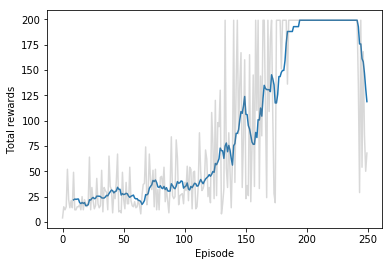

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

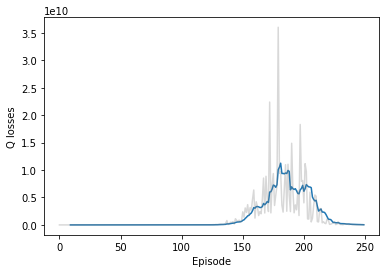

In [36]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

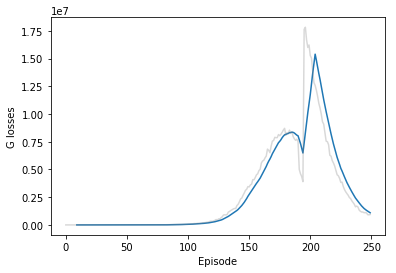

In [37]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

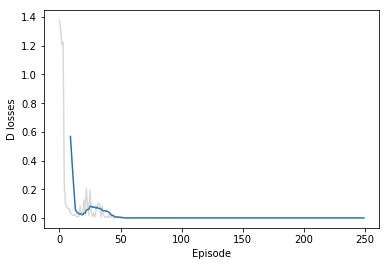

In [38]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.